In [8]:
import numpy as np
import pandas as pd

import torch
import torchvision
# transform is used to convert data into Tensor form with transformations
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [9]:
torch.cuda.is_available()

False

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
trans = transforms.Compose([
    # To resize image
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    # To normalize image
    transforms.Normalize((0.5,), (0.5,))
])

In [12]:
train_set = torchvision.datasets.MNIST(
root = './data',
train = True,
download = True,
transform = trans
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [13]:
test_set = torchvision.datasets.MNIST(
root = './data',
train = False,
download = True,
transform = trans
)

In [14]:
len(train_set), len(test_set)

(60000, 10000)

In [15]:
# this function will generate random indexes between 0 and 59999
def split_indices(n, val_per, seed = 0):
    n_val = int(n * val_per)
    np.random.seed(seed)
    idx = np.random.permutation(n)
    return idx[n_val : ], idx[: n_val]

In [16]:
val_per = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(train_set), val_per, rand_seed)

print(len(train_indices), len(val_indices))

48000 12000


In [17]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 512

# training data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(train_set, batch_size, sampler = train_sampler)

# validation dataloader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(train_set, batch_size, sampler = val_sampler)

In [18]:
class LeNet5(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.num_classes = num_classes
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)  
        )
        
        
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logit = self.classifier(x)
        return logit

In [19]:
# Load Model
model = LeNet5(num_classes = 10)

In [20]:
model

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [24]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    
    pred = model(x)
    
    loss = loss_func(pred, y)
    
    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    
    if metric is not None:
        
        metric_result = metric(pred, y)
        
    return loss.item(), len(x), metric_result

In [25]:
def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric

In [26]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    
    train_losses, val_losses, val_metrics, train_metrics = [], [], [], []
    
    
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            train_loss, _, train_metric = loss_batch(model, loss_fn, x, y, opt_fn, metric)
            
        model.eval()
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        train_metrics.append(train_metric)
        
        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                 .format(epoch+1, epochs, train_loss, val_loss))
            
        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}, train_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric, metric.__name__, train_metric))
            
        if scheduler is not None:
            if scheduler_on == 'val_metric':
                scheduler.step(val_metrics[-1])
        
            
    return train_losses, val_losses, val_metrics, train_metrics

In [27]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

In [28]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print(val_loss, val_acc)

2.3080117270151774 0.09366666666666666


In [31]:
num_epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)

In [32]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Epoch 1/5, train_loss: 0.1559, val_loss: 0.1271, val_accuracy: 0.9623, train_accuracy: 0.9531
Epoch 2/5, train_loss: 0.0614, val_loss: 0.0817, val_accuracy: 0.9759, train_accuracy: 0.9818
Epoch 3/5, train_loss: 0.0779, val_loss: 0.0681, val_accuracy: 0.9793, train_accuracy: 0.9818
Epoch 4/5, train_loss: 0.0913, val_loss: 0.0626, val_accuracy: 0.9817, train_accuracy: 0.9792
Epoch 5/5, train_loss: 0.0523, val_loss: 0.0487, val_accuracy: 0.9848, train_accuracy: 0.9870


Text(0.5, 1.0, 'Plot between Training Loss vs Epochs')

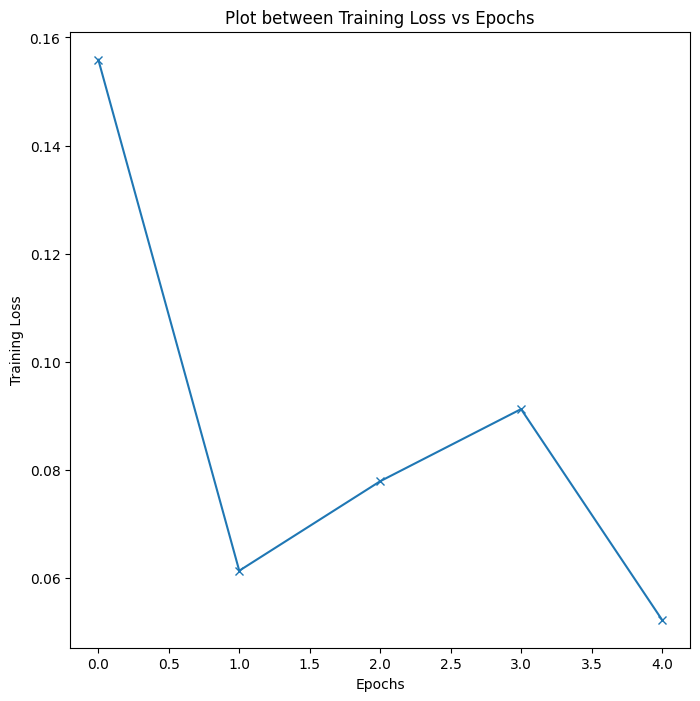

In [33]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-x')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot between Training Loss vs Epochs')

Text(0.5, 1.0, 'Plot between Validation Loss vs Epochs')

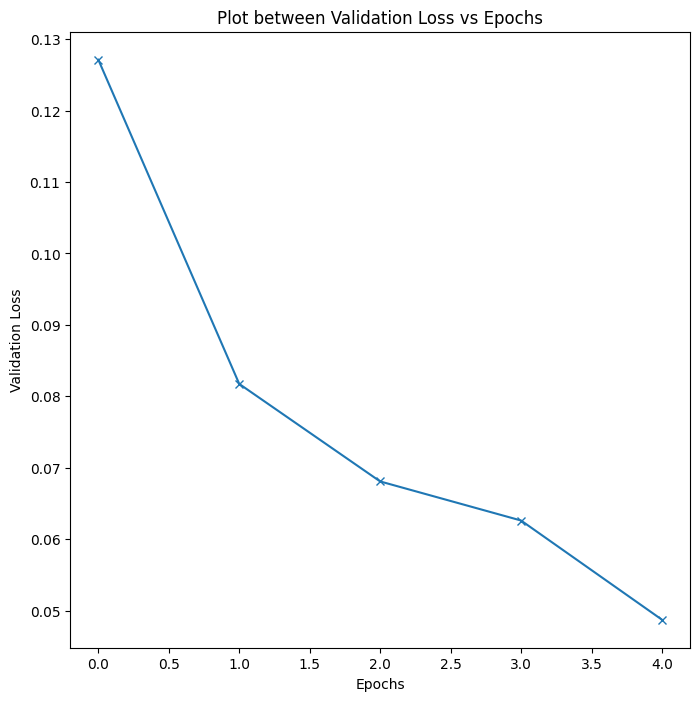

In [34]:
plt.figure(figsize = (8,8))
plt.plot(history[1], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss vs Epochs')

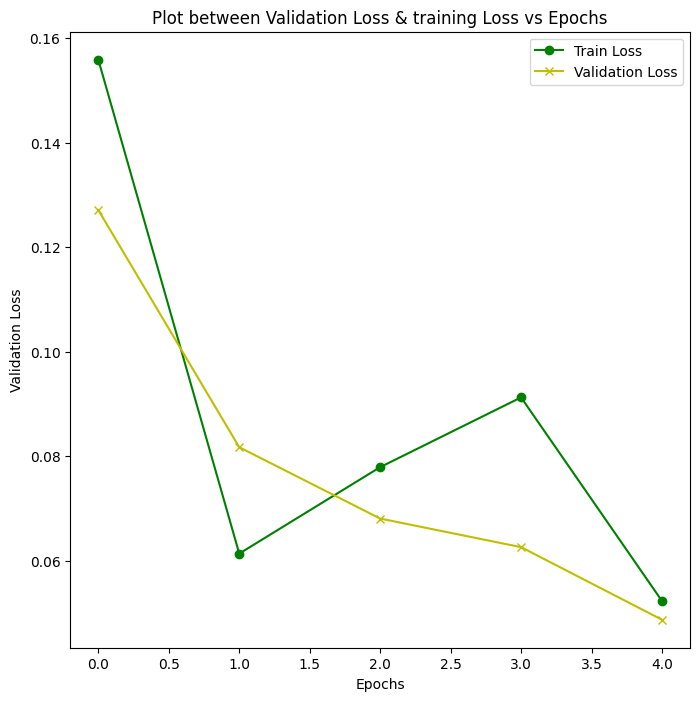

In [35]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-go')
plt.plot(history[1], '-yx')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss & training Loss vs Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')

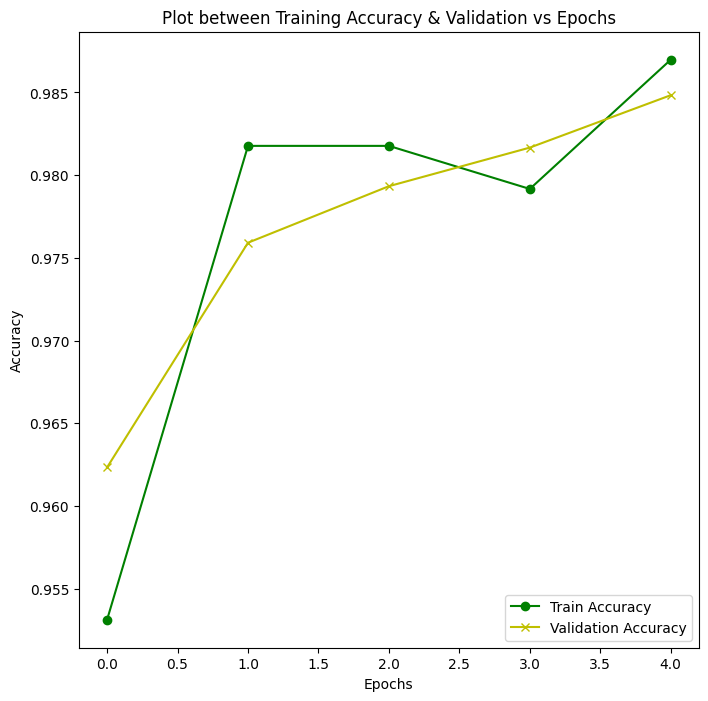

In [36]:
plt.figure(figsize = (8,8))
plt.plot(history[3], '-go')
plt.plot(history[2], '-yx')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot between Training Accuracy & Validation vs Epochs')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')

In [37]:
#test data
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


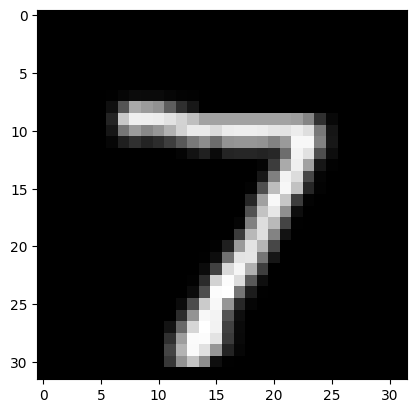

In [38]:
img, label = test_set[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


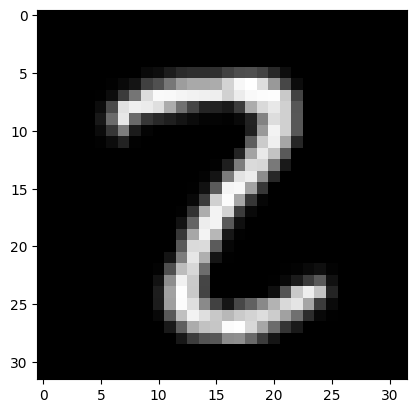

In [39]:
img, label = test_set[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


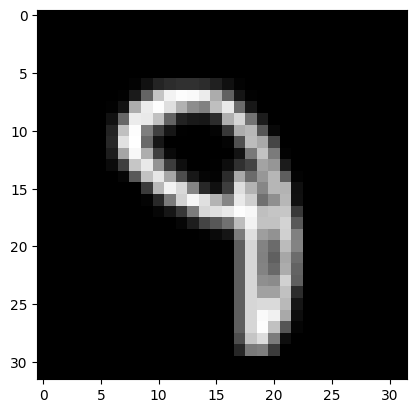

In [40]:
img, label = test_set[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))